In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from utils.experiments import *
from scipy.optimize import curve_fit
from numpy.polynomial import Polynomial

def binary_entropy_m(m):
    """
    Binary entropy as a function of magnetization m in [-1,1]
    """
    # Convert m to probability
    p = (1 + m) / 2
    # Handle edge cases to avoid log(0)
    with np.errstate(divide='ignore', invalid='ignore'):
        H = -p*np.log(p) - (1-p)*np.log(1-p)
    H = np.nan_to_num(H)  # set 0*log(0) -> 0
    return H


In [2]:
res = []

for p in Path(f'results/rs_d=6_c=2').glob('*'):
    a = load_pickle(p)
    res.append(a)
for p in Path(f'results/rs_p=3').glob('*'):
    a = load_pickle(p)
    res.append(a)
for p in Path(f'results/rs_p=2').glob('*'):
    a = load_pickle(p)
    res.append(a)
for p in Path(f'results/rs_p=1').glob('*'):
    a = load_pickle(p)
    res.append(a)
    
df = pd.DataFrame(res)


In [3]:
df =df[df.converged]
df = df[df.p < 4]
df = df[df.d == 6]

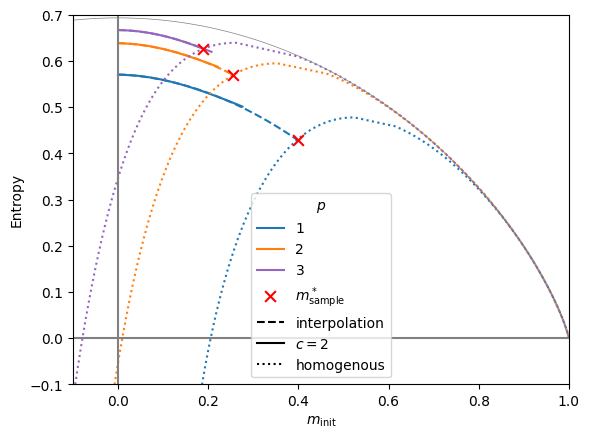

In [4]:


def fit_func_sq(x, a, b, c):
    return a * x**2 + b * x + c

def fit_func(x, a, b, c, d, e):
    return a*x**4 + b*x**3 + c*x**2 + d*x + e

fits = {}
intersections = {}
cs = ['tab:blue', 'tab:orange', 'tab:purple']
colors = iter(cs)

for (p, d), g in df.groupby(['p','d']):
    c = next(colors)
    # --- first fit (quadratic, mag_cycle0 < 0.9) ---
    f1 = g[g.mag_cycle0 < 0.9].sort_values('mag_init')
    x1, y1 = f1.mag_init.values, f1.entropy.values
    popt1, _ = curve_fit(fit_func_sq, x1, y1)

    # --- second fit (quartic, mag_cycle0 isna) ---
    f2 = g[g.mag_cycle0.isna()].sort_values('mag_init')
    x2, y2 = f2.mag_init.values, f2.entropy.values
    popt2, _ = curve_fit(fit_func, x2, y2)

    fits[(p, d)] = (popt1, popt2)

    # --- plotting data and fits ---
    f = g[g.mag_cycle0 < 0.9].sort_values('mag_init')
    plt.plot(f.mag_init, f.entropy,  label=f'{p}',c=c)
    f = g[~(g.mag_cycle0 < 0.9)].sort_values('mag_init')
    plt.plot(f.mag_init, f.entropy,c=c,linestyle=':')
    

    # quartic fit
    #x_fit2 = np.linspace(x2.min(), 1, 200)
    #plt.plot(x_fit2, fit_func(x_fit2, *popt2), linestyle='--', label=f'{p},{d} q4')

    # --- intersection ---
    p1 = Polynomial([popt1[2], popt1[1], popt1[0]])
    p2 = Polynomial([popt2[4], popt2[3], popt2[2], popt2[1], popt2[0]])
    diff = p1 - p2
    roots = diff.roots()
    real_roots = roots[np.isreal(roots)].real
    valid_roots = real_roots[real_roots > 0]

    if len(valid_roots) > 0:
        x_int = np.min(valid_roots)
        y_int = fit_func_sq(x_int, *popt1)
        intersections[(p, d)] = x_int
        plt.scatter(x_int, y_int, color='red', marker='x', s=60, zorder=5)
        # quadratic fit
        x_fit1 = np.linspace(x1.min(), x_int, 200)
        plt.plot(x_fit1, fit_func_sq(x_fit1, *popt1), linestyle='--',c=c)
    else:
        intersections[(p, d)] = None
m = np.linspace(-0.2, 1, 100)
H = binary_entropy_m(m)
plt.plot(m, H, color='grey', lw=0.5)
plt.scatter([], [], color='red', marker='x', s=60, zorder=5,label='$m^*_{\mathrm{sample}}$')

plt.axhline(0.0,c='gray')
plt.axvline(0.0,c='gray')
plt.ylim(-0.2, 0.8)
plt.xlabel('$m_{\mathrm{init}}$')
plt.ylabel('Entropy')
plt.plot([],[],label='interpolation',c='black',linestyle='--')
plt.plot([],[],label='$c=2$',c='black')
plt.plot([],[],label='homogenous',c='black',linestyle=':')
plt.legend(title='$p$')
plt.xlim(-0.1,1.0)
plt.ylim(-0.1,0.7)
plt.savefig('figures/static-1RSB_entropy_vs_minit.png', bbox_inches='tight', dpi=300)
plt.show()


In [30]:
print(intersections)

{(np.int64(1), np.int64(6)): np.float64(0.3984347094005665), (np.int64(2), np.int64(6)): np.float64(0.25518606221316353), (np.int64(3), np.int64(6)): np.float64(0.18833459726606172)}
